In [5]:
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
#S = 500

# time inteval

delta = 1/12

#n = int(S/delta)
n = 5000

# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

5001


In [7]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A100 80GB PCIe


In [8]:
#L = 1500000

kappa_range = [0.1, 3]
beta_range = [-1, 1]
sigma2_range = [0.1, 1.5]

lambda_range = [0.01, 1]
mu_range = [0.1,1.5]

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from DNN_module import Net
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Default : cuda
torch.set_default_device('cuda')

# Define the batch size
BATCH_SIZE = 64

# Number of Epochs
N_EPOCHS = 350
    
# Number of Simulations
sims = 10

# Number of observation
#nums = [500, 1000, 3000]

for sim in range(0,1):
        # Data import
        sim_path = "../../../depot_hyun/hyun/MROUJ/MROUJ_sim" + str(sim) + "_" + str(n)+ ".pt"
        [X_raw, output] = torch.load(sim_path)
        X_raw = X_raw.to("cpu")
        
        
        c_tmp = torch.quantile(X_raw, torch.tensor([.0001,.9999], device = "cpu"), 0)
        a = torch.reshape(c_tmp[0], (1, c_tmp.size()[1]))
        b = torch.reshape(c_tmp[1], (1, c_tmp.size()[1]))

        X = torch.clone((X_raw - a) / (b - a))
        
        scale_path = "MROUJ_sim/MROUJ_scale/MROUJ_scale" + str(sim) + "_" + str(n)+ ".pt"
        torch.save([a,b], scale_path)

        torch.set_default_device(dev)
        X = X.to(dev)
        output = output.to(dev)
        
        L = X.size()[0]
        Lval = 40000
        Ltest = 10000
        
        X_train = X[range(0,L-Lval-Ltest),:]
        y_train = output[range(0,L-Lval-Ltest),:]

        X_val = X[range(L-Lval-Ltest,L-Ltest),:]
        y_val = output[range(L-Lval-Ltest,L-Ltest),:]

        X_test = X[range(L-Ltest,L),:]
        y_test = output[range(L-Ltest,L),:]

        print(X_train.size(), X_val.size(),X_test.size())
        
        
        # Use torch.utils.data to create a DataLoader that will take care of creating batches
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))

        # Get the dataset size for printing (it is equal to N_SAMPLES)
        dataset_size = len(dataloader.dataset)
        
        # Define the input and output dimensions
        D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

        # Create an instance of the Net class with specified dimensions
        torch.manual_seed(2725)
        net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)

        # Model name
        model_save_name = 'MROUJ_nets/MROUJ_' + str(sim) + '_'  + str(n) + '.pt'
        path = F"./{model_save_name}"

        # The nn package also contains definitions of popular loss functions; in this case we will use Mean Squared Error (MSE) as our loss function.
        def weighted_mse_loss(input, target, weight):
            return (weight * (input - target) ** 2).sum()
    
        out_range = [torch.quantile(y_train,.01, 0).detach().cpu().numpy(), 
                     torch.quantile(y_train,.99, 0).detach().cpu().numpy()]
        weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)

        learning_rate = 1e-5
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

        train_error_plt = []
        val_error_plt = []

        torch.manual_seed(2000 + sim)
        # Loop over epochs
        file = open("log/MROUJ_sim.txt","a")
        file.write(sim_path + "start" + "sim: " + str(sim)+ "\n")
        file.close()
        

        # Loop over epochs
        for epoch in range(N_EPOCHS):
            for id_batch, (x_batch, y_batch) in enumerate(dataloader):
                y_batch_pred = net(x_batch)
                loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if epoch % 50 ==0 and id_batch % 100 == 0:
                    loss, current = loss.item(), (id_batch + 1)* len(x_batch)
                    print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

            with torch.no_grad():
                net.eval()
                theta_pred_train = net(X_train)
                train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) / (L-Lval-Ltest)
                train_error_plt.append(train_loss.to("cpu"))

                theta_pred_val = net(X_val)
                val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
                val_error_plt.append(val_loss.to("cpu"))

            if epoch % 10 ==0:
                print(f"Epoch {epoch + 1}\n-------------------------------")
                print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
                print("learning rate: ", learning_rate, "sim: ", sim)

            # Choose Best Model
            if val_error_plt[epoch] == np.min(val_error_plt):
                best=epoch
                torch.save(net.state_dict(), path)

            if epoch % 100 ==99:
                net.load_state_dict(torch.load(path))
                learning_rate = max(learning_rate * 1e-1, 1e-9)
            print(min(val_error_plt))
            
            
        file = open("log/MROUJ_sim.txt","a")
        file.write(sim_path + "end" + "sim: " + str(sim) + "\n")
        file.close()


torch.Size([200000, 72]) torch.Size([40000, 72]) torch.Size([10000, 72])
train_loss: 1.245138  [   64/200000]
train_loss: 0.454087  [ 6464/200000]
train_loss: 0.232183  [12864/200000]
train_loss: 0.217672  [19264/200000]
train_loss: 0.137945  [25664/200000]
train_loss: 0.112720  [32064/200000]
train_loss: 0.090326  [38464/200000]
train_loss: 0.085999  [44864/200000]
train_loss: 0.081056  [51264/200000]
train_loss: 0.073415  [57664/200000]
train_loss: 0.083282  [64064/200000]
train_loss: 0.079479  [70464/200000]
train_loss: 0.061348  [76864/200000]
train_loss: 0.060433  [83264/200000]
train_loss: 0.070270  [89664/200000]
train_loss: 0.097602  [96064/200000]
train_loss: 0.073423  [102464/200000]
train_loss: 0.067684  [108864/200000]
train_loss: 0.054598  [115264/200000]
train_loss: 0.052288  [121664/200000]
train_loss: 0.061354  [128064/200000]
train_loss: 0.055967  [134464/200000]
train_loss: 0.046349  [140864/200000]
train_loss: 0.060967  [147264/200000]
train_loss: 0.041817  [153664/2

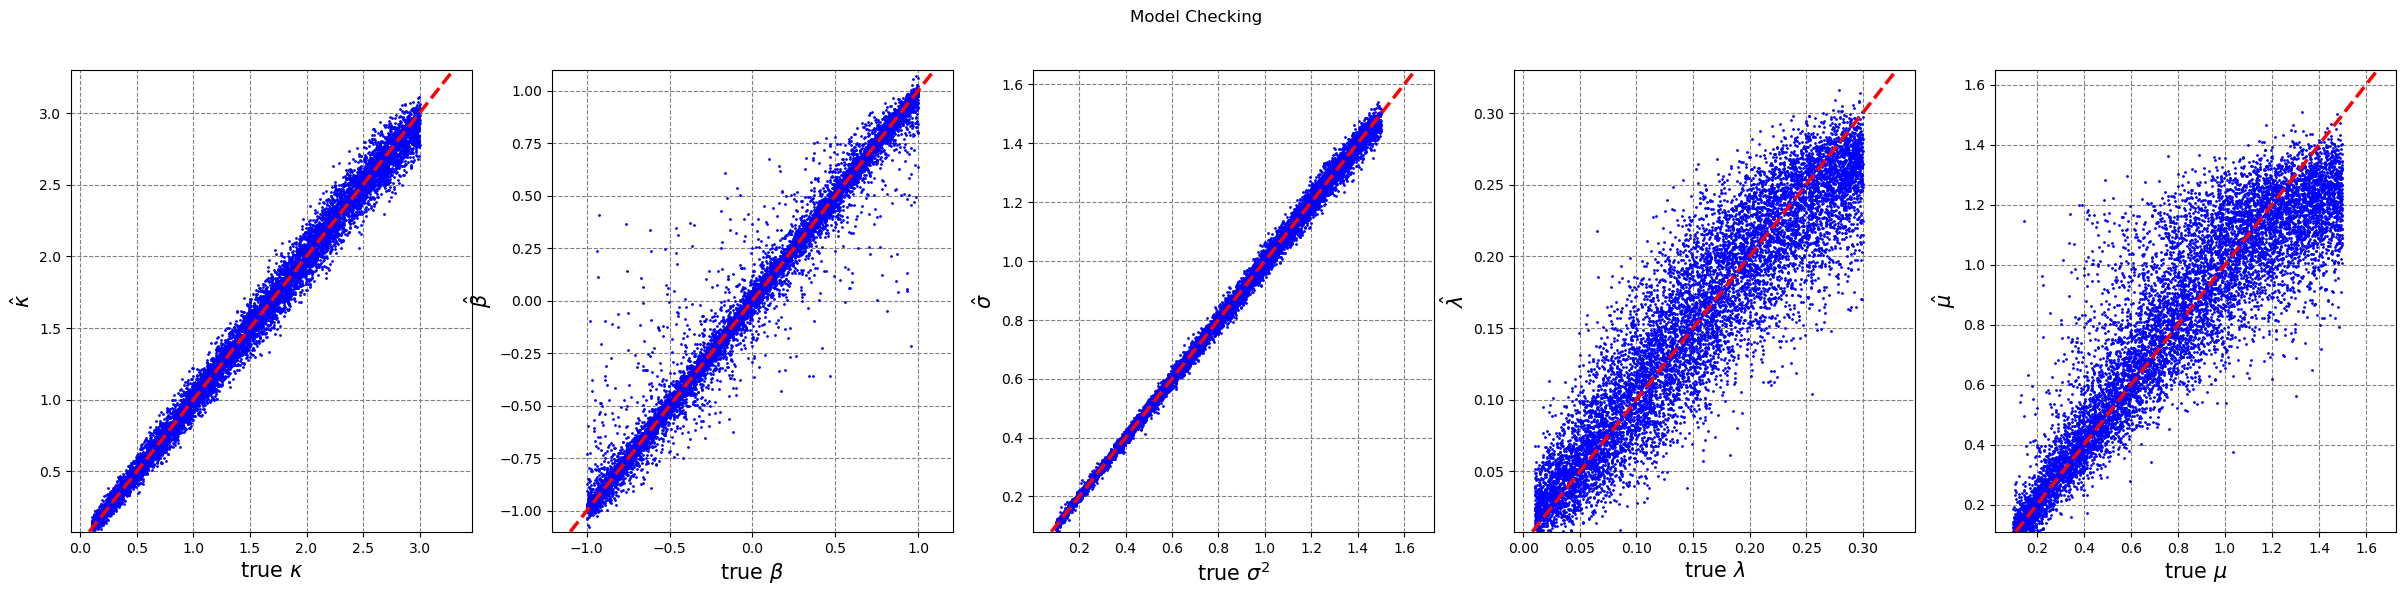

In [168]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']
#esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp1 = net(X_test)[:,0]
    tmp2 = net(X_test)[:,1]
    tmp3 = net(X_test)[:,2]
    tmp4 = net(X_test)[:,3]
    tmp5 = net(X_test)[:,4]

tmp = [tmp1.detach().cpu().numpy().tolist(),
       tmp2.detach().cpu().numpy().tolist(),
       tmp3.detach().cpu().numpy().tolist(),
       tmp4.detach().cpu().numpy().tolist(),
       tmp5.detach().cpu().numpy().tolist()]


## Plot for model checking
lim = [[kappa_range[0] * 0.8, kappa_range[1] * 1.1]
       ,[beta_range[0] * 1.1, beta_range[1] * 1.1]
       ,[sigma2_range[0] * 0.8, sigma2_range[1] * 1.1]
       ,[lambda_range[0] * 0.8, lambda_range[1] * 1.1]
       ,[mu_range[0] * 1.1, mu_range[1] * 1.1]]
#lim = [[kappa_range[0] * 0.8, kappa_range[1] * 1.1]
#       ,[beta_range[0] * 1.1, beta_range[1] * 1.1]
#       ,[lambda_range[0] * 0.8, lambda_range[1] * 1.1]
#       ,[mu_range[0] * 1.1, mu_range[1] * 1.1]]

fig, axes = plt.subplots(1, len(tmp), figsize=(30,6))
fig.suptitle('Model Checking', fontsize = 40)

for i in range(len(tmp)):
    lim1 = lim[i]
    tmp1 = tmp[i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim(lim1)

#fig.tight_layout()
#fig.savefig("JOU_plots/MROUJ.pdf") 